**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

Tiene  como  objetivo  el  entrenamiento  y  evaluación  de  un  modelo  con  el  dataset 
seleccionado usando una arquitectura de Perceptrón Multicapa. condiciones de entrenamiento, evaluación, conclusiones

# Entrega 1 - Perceptrón Multicapa

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación del dataset

Importamos las librerías

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from imblearn.under_sampling import NearMiss
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import re

Importamos el dataset y lo almacenamos como un dataframe de pandas. Verificamos que no hayan datos faltantes y convertimos la salidas en números usando one hot encoding

In [2]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])

print("Clasificación Original: ", dataset.airline_sentiment.unique(),"\n")

#Se reemplaza negative por 0, neutral por 1 y positive por 2
dataset["airline_sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)

#dataset.describe(include='all')
dataset.info()
print("\nAerolíneas: ", dataset.airline.unique())
print("Clasificación one hot encoder: ", dataset.airline_sentiment.unique())

Clasificación Original:  ['neutral' 'positive' 'negative'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  int64 
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: int64(1), object(2)
memory usage: 343.3+ KB

Aerolíneas:  ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Clasificación one hot encoder:  [1 2 0]


C:\Users\USUARIO\AppData\Local\Temp;\ipykernel_3448\879290016.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["airline_sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


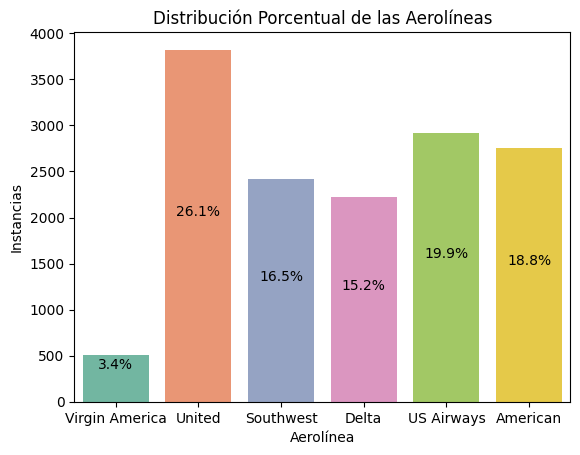

In [3]:
graphAirline = sns.countplot(x="airline", hue="airline", data=dataset, palette="Set2", legend=False)
total = len(dataset)

for p in graphAirline.patches:
    count = p.get_height() #frecuencia absoluta
    percent = 100 * count / total #frecuencia relativa
    
    graphAirline.annotate(f'{percent:.1f}%', # formato de texto
        (p.get_x() + p.get_width() / 2., count/2),  #posición
        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points')
    
graphAirline.set_xlabel("Aerolínea")
graphAirline.set_ylabel("Instancias")
graphAirline.set_title("Distribución Porcentual de las Aerolíneas")


plt.show()

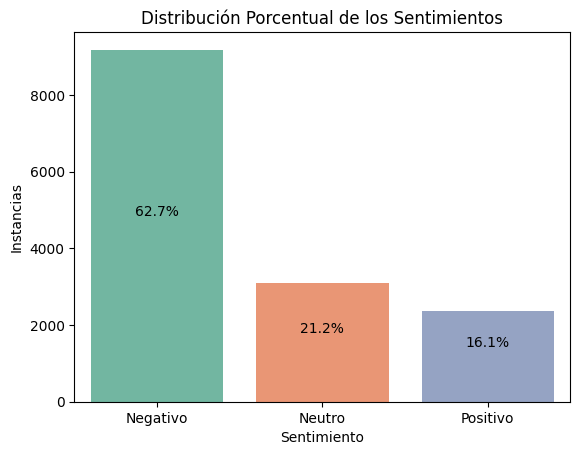

In [4]:
graphOutput = sns.countplot(x="airline_sentiment", hue="airline_sentiment",  data=dataset, palette="Set2", legend=False)
total = len(dataset)

for p in graphOutput.patches:
    count = p.get_height() #frecuencia absoluta
    percent = 100 * count / total #frecuencia relativa
    
    graphOutput.annotate(f'{percent:.1f}%', # formato de texto
        (p.get_x() + p.get_width() / 2., count/2),  #posición
        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points')
    
ticks = graphOutput.get_xticks()
graphOutput.set_xticks(ticks)
graphOutput.set_xticklabels(["Negativo", "Neutro", "Positivo"])
graphOutput.set_xlabel("Sentimiento")
graphOutput.set_ylabel("Instancias")
graphOutput.set_title("Distribución Porcentual de los Sentimientos")

plt.show()

Como el dataset está compuesto por cadenas de texto, será pre procesado antes de iniciar el entrenamiento

In [5]:
nltk.download('stopwords')
palVacias = set(stopwords.words('english')) 
palRaiz = SnowballStemmer('english')
tokenizador = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")
usuarios = r"@\w*"
hashtags = r"#(\w+)"

def preprocesamiento (tweet, stem=True):
    tweet = re.sub(usuarios, "", tweet)
    tweet = re.sub(hashtags, r"\1", tweet)
    tweet = re.sub(r"\b(\w+)n't\b", "not", tweet, flags=re.IGNORECASE) #Para las negaciones
    
    palabras = tokenizador.tokenize(tweet)
    texto = []
    for palabra in palabras: 
        palabra_lower = palabra.lower()
        # Conserva "no" aunque sea stopword
        if palabra_lower == "not" or palabra_lower == "no" or palabra_lower not in palVacias:
            if stem:
                texto.append(palRaiz.stem(palabra).lower())
            else:
                texto.append(palabra_lower)
    
    return tokenizador.tokenize(" ".join(texto))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Los enlaces se muestran como palabras: 'http', 'co', 'vhp2gtdwpk'
print(f"Texto Original: {dataset.text[39]}")
print(f"\nTexto Preprocesado: {preprocesamiento(dataset.text[39])}")
dataset.head()

Texto Original: @VirginAmerica Your chat support is not working on your site: http://t.co/vhp2GtDWPk

Texto Preprocesado: ['chat', 'support', 'not', 'work', 'site', 'http', 'co', 'vhp2gtdwpk']


,airline_sentiment,airline,text
0,1,Virgin America,@VirginAmerica What @dhepburn said.
1,2,Virgin America,@VirginAmerica plus you've added commercials t...
2,1,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,0,Virgin America,@VirginAmerica it's really aggressive to blast...
4,0,Virgin America,@VirginAmerica and it's a really big bad thing...


In [7]:
#Aplicar preprocesamiento a todo el dataset
dataset["token"] = dataset.text.map(preprocesamiento)
dataset.head()

,airline_sentiment,airline,text,token
0,1,Virgin America,@VirginAmerica What @dhepburn said.,[said]
1,2,Virgin America,@VirginAmerica plus you've added commercials t...,"[plus, ad, commerci, experi, tacki]"
2,1,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[not, today, must, mean, need, take, anoth, trip]"
3,0,Virgin America,@VirginAmerica it's really aggressive to blast...,"[realli, aggress, blast, obnoxi, entertain, gu..."
4,0,Virgin America,@VirginAmerica and it's a really big bad thing...,"[realli, big, bad, thing]"


In [8]:
vectorizador = TfidfVectorizer(analyzer=lambda x: x)
matriz = vectorizador.fit_transform(dataset["token"])
dataset["rep"] = [row.toarray().flatten().tolist() for row in matriz]
dataset.head()

,airline_sentiment,airline,text,token,rep
0,1,Virgin America,@VirginAmerica What @dhepburn said.,[said],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Virgin America,@VirginAmerica plus you've added commercials t...,"[plus, ad, commerci, experi, tacki]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[not, today, must, mean, need, take, anoth, trip]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,Virgin America,@VirginAmerica it's really aggressive to blast...,"[realli, aggress, blast, obnoxi, entertain, gu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Virgin America,@VirginAmerica and it's a really big bad thing...,"[realli, big, bad, thing]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Ahora, vamos a revisar la revisión porcentual de los datos para asegurarnos de que el conjunto sea representativo

La distribución de los datos no está balanceada. La aerolínea Virgin América tiene muchas menos instancias que las demás, y United tiene muchas más, así que implementamos la técnica del Submuestreo Near Miss para equilibrar los datos.

In [9]:
submuestreo = NearMiss()
x = np.vstack(dataset["rep"].values)
y = dataset["airline_sentiment"].values

xBal, yBal = submuestreo.fit_resample(x, y)
indicesBal = submuestreo.sample_indices_

datasetBal = dataset.iloc[indicesBal].copy().reset_index(drop=True)
datasetBal.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7089 entries, 0 to 7088
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  7089 non-null   int64 
 1   airline            7089 non-null   object
 2   text               7089 non-null   object
 3   token              7089 non-null   object
 4   rep                7089 non-null   object
dtypes: int64(1), object(4)
memory usage: 277.0+ KB


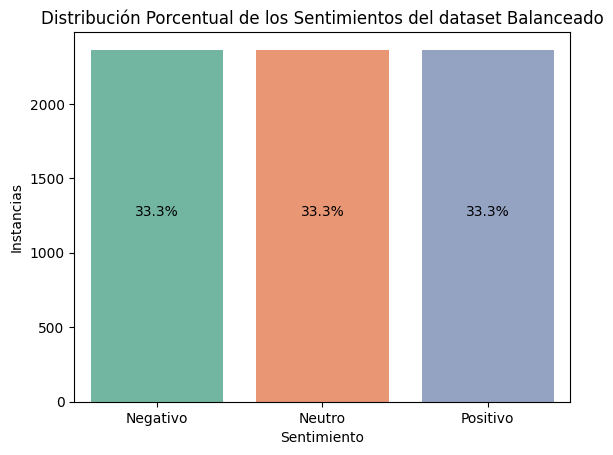

In [10]:
graphOutput = sns.countplot(x="airline_sentiment", hue="airline_sentiment",  data=datasetBal, palette="Set2", legend=False)
total = len(datasetBal)

for p in graphOutput.patches:
    count = p.get_height() #frecuencia absoluta
    percent = 100 * count / total #frecuencia relativa
    
    graphOutput.annotate(f'{percent:.1f}%', # formato de texto
        (p.get_x() + p.get_width() / 2., count/2),  #posición
        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points')
    
ticks = graphOutput.get_xticks()
graphOutput.set_xticks(ticks)
graphOutput.set_xticklabels(["Negativo", "Neutro", "Positivo"])
graphOutput.set_xlabel("Sentimiento")
graphOutput.set_ylabel("Instancias")
graphOutput.set_title("Distribución Porcentual de los Sentimientos del dataset Balanceado")

plt.show()

In [11]:
n = len(datasetBal)
cTrain = int(n*0.7) # 70% para entrenar y 30% para probar
cTest = n-cTrain
print(f"N = {n} | Tamaño entrenamiento = {cTrain} | Tamaño prueba = {cTest}")
trainData, testData = train_test_split(datasetBal, train_size=cTrain, test_size=cTest)
testData.head()

N = 7089 | Tamaño entrenamiento = 4962 | Tamaño prueba = 2127


,airline_sentiment,airline,text,token,rep
2468,1,Virgin America,"@VirginAmerica has getaway deals through May, ...","[getaway, deal, may, 59, one, way, lot, cool, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2200,0,American,@AmericanAir What is that!? Why even bother ...,"[even, bother, cater, dog, food, no, one, eat,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5657,2,Southwest,@SouthwestAir that's awesome! Love flying SWA!,"[that, awesom, love, fli, swa]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5092,2,United,"@united gave me a smile today, with a Zero Awa...","[gave, smile, today, zero, award, comput, sens...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6678,2,US Airways,@USAirways ok thank you we were told ground de...,"[ok, thank, told, ground, delay, due, snow]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [94]:
cantClases = 3
sizeVocab = np.vstack(trainData.rep.values).shape[1]
print(sizeVocab)

modelo = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(sizeVocab,)),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(cantClases, activation="softmax")
])
opt = SGD(learning_rate=0.01, momentum=0.0)
modelo.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

11502


C:\Users\USUARIO\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
def entrenamiento (xTrain, yTrain, xTest, yTest, modelo, epocas, lote):
    history = modelo.fit(
        xTrain, yTrain,
        validation_data = (xTest, yTest),
        epochs = epocas,
        batch_size = lote,
        verbose = 1
    )
    return history

In [96]:
xTrain = np.array(trainData["rep"].to_list(), dtype="float32")
yTrain = trainData.airline_sentiment.values
xTest = np.array(testData["rep"].to_list(), dtype="float32")
yTest = testData.airline_sentiment.values
epocas = 100
lote = 32

In [97]:
resultado = entrenamiento(xTrain, yTrain, xTest, yTest, modelo, epocas, lote)

resultados = {
    "Época": ["Primera", "Última"],
    "Loss": [resultado.history["loss"][0], resultado.history["loss"][-1]],
    "Val_Loss": [resultado.history["val_loss"][0], resultado.history["val_loss"][-1]],
    "Accuracy": [resultado.history["accuracy"][0], resultado.history["accuracy"][-1]],
    "Val_Accuracy": [resultado.history["val_accuracy"][0], resultado.history["val_accuracy"][-1]],
}

tabla = pd.DataFrame(resultados)
print(tabla)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3549 - loss: 1.0978 - val_accuracy: 0.4048 - val_loss: 1.0968
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3998 - loss: 1.0953 - val_accuracy: 0.3709 - val_loss: 1.0946
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4043 - loss: 1.0928 - val_accuracy: 0.4358 - val_loss: 1.0912
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4293 - loss: 1.0890 - val_accuracy: 0.4965 - val_loss: 1.0873
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4528 - loss: 1.0835 - val_accuracy: 0.4894 - val_loss: 1.0833
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4490 - loss: 1.0799 - val_accuracy: 0.5421 - val_loss: 1.0789
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4782 - loss: 1.0742 - val_accuracy: 0.5689 - val_loss: 1.0733
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4946 - loss: 1.0685 - val_acc

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


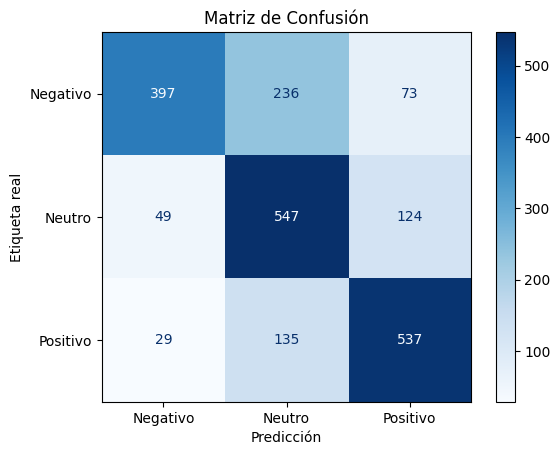

In [98]:
yPred = modelo.predict(xTest)
yPred_classes = yPred.argmax(axis=1)

# Matriz de confusión
cm = confusion_matrix(yTest, yPred_classes)
class_names = ['Negativo', 'Neutro', 'Positivo']

# Graficar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")

plt.show()

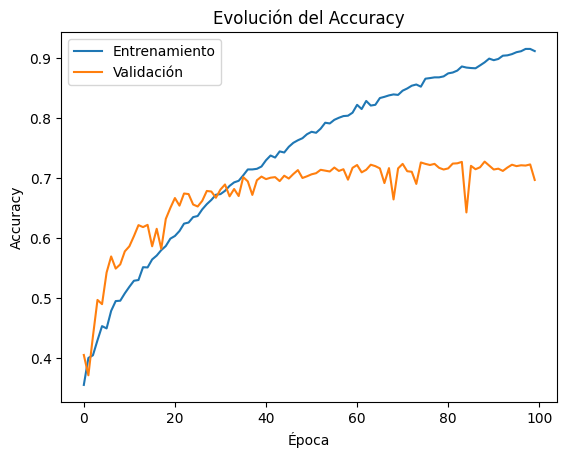

In [99]:
# Accuracy
plt.plot(resultado.history["accuracy"], label="Entrenamiento")
plt.plot(resultado.history["val_accuracy"], label="Validación")
plt.title("Evolución del Accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

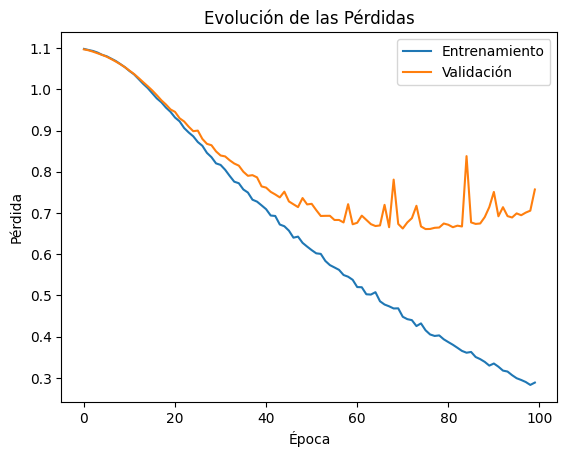

In [100]:
plt.plot(resultado.history["loss"], label="Entrenamiento")
plt.plot(resultado.history["val_loss"], label="Validación")
plt.title("Evolución de las Pérdidas")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()